# Zillow: What is driving the errors in the Zestimates?

---

Project & Final Report Created By: Rachel Robbins-Mayhill 2022-04-08

---

<img src='Zestimate.png' width="1000" height="1000" align="center"/>

## PROJECT DESCRIPTION

Zillow is the leading real estate and rental marketplace dedicated to empowering consumers with data, inspiration and knowledge around the place they call home, and connecting them with the best local professionals who can help. According to the National Association of Realtors, there are over 119 million homes in the United States, over 5 million of which are sold each year. 80% of these homes have been viewed on Zillow regardless of their market status.

Zillow serves the full lifecycle of owning and living in a home: buying, selling, renting, financing, remodeling and more. It starts with Zillow's living database of more than 110 million U.S. homes - including homes for sale, homes for rent and homes not currently on the market, as well as Zestimate home values, Rent Zestimates and other home-related information.

The Zestimate is a key element driving webtraffic to Zillow, where sellers, buyers, agents, and curiosity-seekers gain knowledge of a home's value. In fact, over the years, Zillow has built a solid reputation around the Zestimate. The Zestimate takes in layers of data regarding a homes features and location and presents buyers and sellars with a value of a home. Zillow publishes Zestimates for 104 million homes, updating them weekly.

Although Zillow has a model to assist in predicting a home's value, they are looking to fine-tune the model and **improve the Zestimate Residual Error**. This project has been requested by the Zillow Data Science Team.

### PROJECT GOAL

The goal of this project is to **find key drivers of logerror** for Single Family Properties and to construct a Machine Learning Regression Model to improve the Zestimate Residual Error (logerror). The model will help Zillow develop more accurate, dependable, and trustworthy Zestimates, thus sustaining and bolstering their loyal customer base. 

Upon completion of the model, the project will make recommendations on what does and doesn't impact logerror and deliver the recommendations in a report to the Data Science team at Zillow, so they can understand the process that developed the conclusion and have the information available to replicate the findings. 

### INITIAL QUESTIONS

Questions
1. Is there a relationship between logerror and lot size in each county?
2. Is there a relationship between logerror and finished square footage of the property in each county?
3. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?
4. Is there a relationship between logerror and zipcode?
5. Controlling for property square footage, what is the relationship between logerror and age of the home?

---

Imports used for this project can be viewed in the imports.py file located in the Clustering Project Repository.

In [2]:
from imports import *

### I. Acquire the Data

The data for this report was acquired by accessing 'zillow' from the Codeup SQL database. The following query was used to acquire the data:

In [3]:
'''
The query below is used to join 9 tables from the zillow dataset in the Codeup SQL Cloud Database.  
The tables joined are: properties_2017, predictions_2017, airconditioningtype, architecturalstyletype, 
buildingclasstype, heatingorsystemtype, propertylandusetype, storytype, typeconstructiontype. 
The data is filtered to only include the observationswith non-null latitude and longitude and with a 
transaction date occurring in 2017. 
'''

sql = """
SELECT prop.*, 
       pred.logerror, 
       pred.transactiondate, 
       air.airconditioningdesc, 
       arch.architecturalstyledesc, 
       build.buildingclassdesc, 
       heat.heatingorsystemdesc, 
       landuse.propertylandusedesc, 
       story.storydesc, 
       construct.typeconstructiondesc 
FROM   properties_2017 prop  
       INNER JOIN (SELECT parcelid,
       					  logerror,
                          Max(transactiondate) transactiondate 
                   FROM   predictions_2017 
                   GROUP  BY parcelid, logerror) pred
               USING (parcelid) 
       LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
       LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
       LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
       LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
       LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
       LEFT JOIN storytype story USING (storytypeid) 
       LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
WHERE  prop.latitude IS NOT NULL 
       AND prop.longitude IS NOT NULL AND transactiondate <= '2017-12-31' 
"""

In [4]:
# Acquire data from SQL using module found in wrangle.py
df = wrangle.get_zillow()
# Obtain number of rows and columns for orginal dataframe
df.shape

Reading from csv file...


(77381, 67)

### Original DF -> 77,381 rows and 67 columns.

### II. Prepare the Data

This acquired table was then analyzed and cleaned to eliminate data errors, clarify confusion, and code non-numeric data into more useful numeric types. 

#### Tasks for preparing data
Some of the data cleaning and engineering strategies that were employed were:

1. Filtered for only single family residences, including: 
    - #261: Single Family Residential, #262: Rural Residence, #263: Mobile Homes, #264: Townhomes, #265 Cluster Homes, #266: Condominium, #268: Row House,  #273 Bungalow, #275 Manufactured, #276 Patio Home, #279 Inferred Single Family Residence
2. Dropping null values (17 columns, and 15,172 rows in total)
    - dropped columns first wit over 50% missing values, then dropped rows with over 50% missing values. 
3. Dropped Unnecessary / Duplicate columns:
    - censustractandblock','finishedsquarefeet12','buildingqualitytypeid', 'heatingorsystemtypeid', 'propertyzoningdesc', 'heatingorsystemdesc', 'unitcnt' column
4. Clarifying the FIPS/state_county_code definition, identifying the State and Counties the codes belong to.
5. Creating a separate column identifying the county for each property in string format for readability -> county_code_bin
6. Creating dummy columns for county codes.
7. Creating categorical columns to better visualize and compare data for:
    - 7a. square feet -> home_sizes (small, medium, large, extra large)
    - 7b. total rooms -> total_rooms (bedrooms + bathrooms)
    - 7c. bedroom bins -> small, medium, large, extra large
    - 7d. bathroom bins -> small, medium, large, extra large

#### Results of Preparing the Data

In [5]:
df = wrangle.single_family_homes(df)

In [6]:
df= wrangle.remove_columns(df, cols_to_remove = ['censustractandblock','finishedsquarefeet12',
                                     'buildingqualitytypeid', 'heatingorsystemtypeid', 'propertyzoningdesc', 
                                     'heatingorsystemdesc', 'unitcnt'])

In [7]:
df = wrangle.data_prep(df, prop_required_column=.5, prop_required_row=.5)

(62209, 38)


In [11]:
# View of the first 5 rows of the cleaned table
df.shape

(62209, 38)

### Prepared DF -> 62,210 rows and 33 columns.

### Splitting the Data

After preparing the data, it was split into 3 samples; train, validate, and test using:
- Random State: 123
- Splits of: 
    - Test -> 20% of the original dataset. 
    - The remaining 80% of the dataset is divided between valiidate and train
    - Validate (.30*.80) -> 24%  
    - Train (.70*.80) -> 56% 

In [15]:
train, validate, test = wrangle.split_data(df)

Train: 34836 rows, 38 cols
Validate: 14931 rows, 38 cols
Test: 12442 rows, 38 cols


# EXPLORE

Exploration started with looking at the distribution of logerror which appeared to be normally distributed.

### Explore - Univariate

[(-1.0, 1.0), (0.0, 1500.0)]

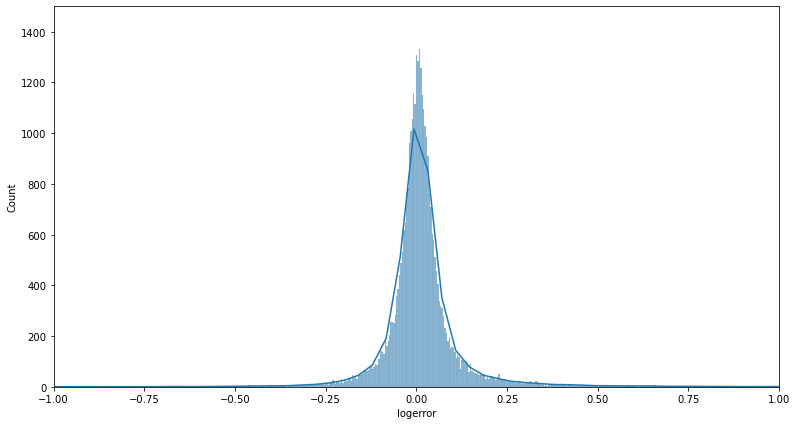

In [16]:
plt.figure(figsize = (13,7))
# Create histogram
ax = sns.histplot(data=train, x="logerror", kde=True)
# set x and y limits to 'zoom in'
ax.set(xlim = (-1, 1), ylim = (0, 1500)) # set the limits to the desired

### Explore - Bivariate

Following the correlation, a pairplot was used to visualize relationships between variables. 

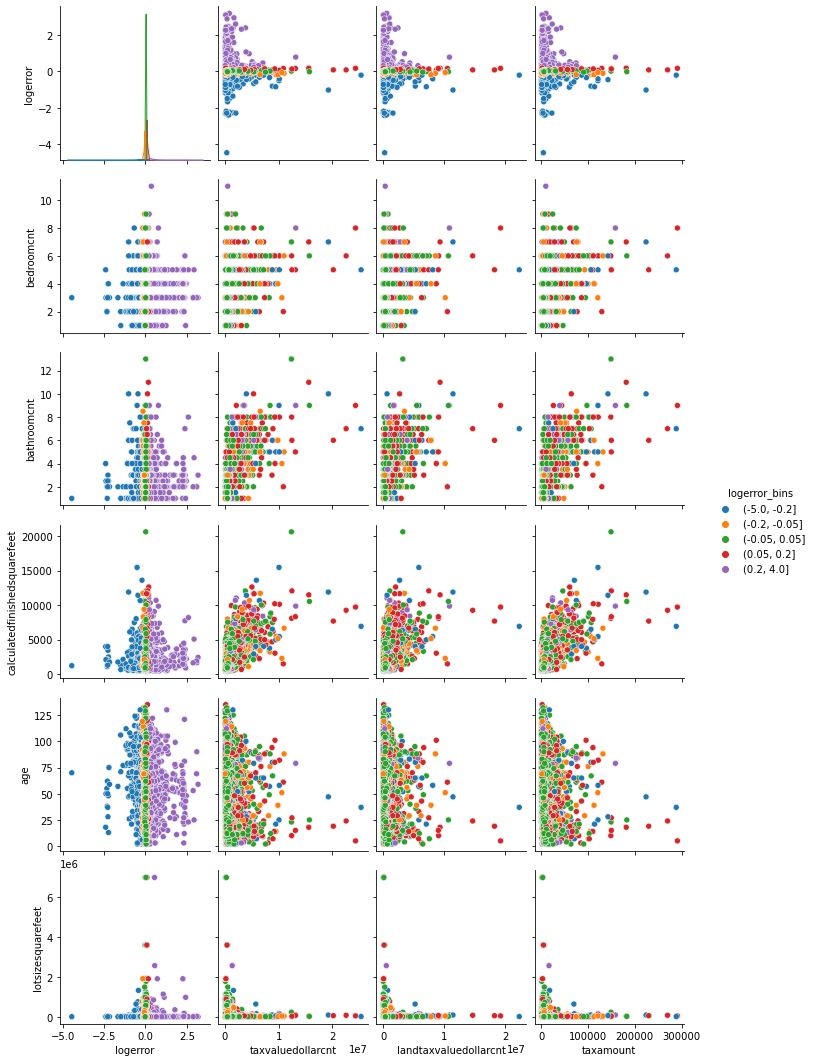

In [17]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount'],
             y_vars = ['logerror', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'age', 'lotsizesquarefeet'])

### Exploration Observations / Takeaways:
- logerror appears to be normally distributed
- logerror higher with odd numbers of bedrooms
- logerror higher when bathrooms have complete number; lower logerror with halfbaths
- logerror higher with calculated squarefeet > 4000
- logerror higher with homes ages between 5 and 80; tend to zillow model tends to overestimate with age
- need to look at lotsize and log error in more detail to see if there is a relationship
- logerror higher with homes that have taxvaluedollarcnt & landtaxvaluedoallarcnt < 500_000, and taxamount < 50_000

## EXPLORE - QUESTIONS

### Questions

- 1. Is there a relationship between logerror and *lot size* in each county?
- 2. Is there a relationship between logerror and finished square footage of the property in each county?
- 3. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?
- 4. Is there a relationship between logerror and zipcode?
- 5. Controlling for property square footage, what is the relationship between logerror and age of the home?

---

### QUESTION 1: LOGERROR & LOT SIZE

#### Is there a relationship between logerror and *lot size* square footage in each county?

#### Visualization 

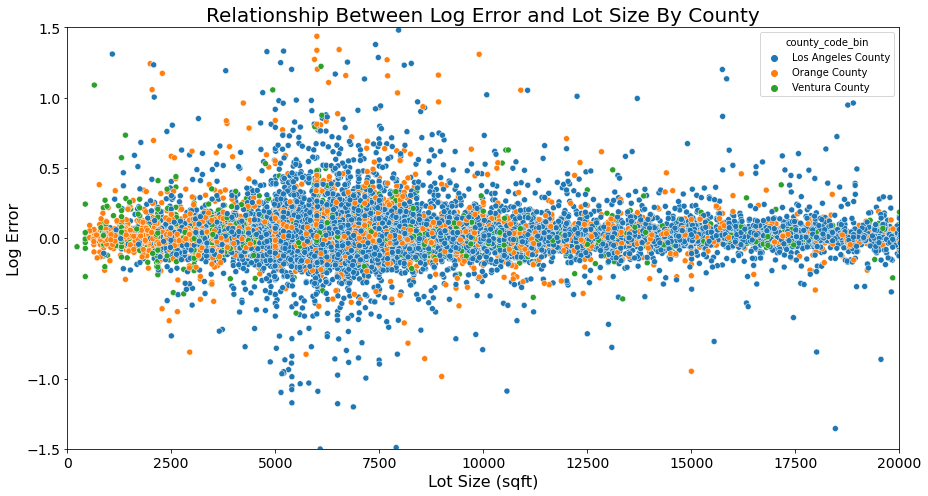

In [18]:
x = train.lotsizesquarefeet
y = train.logerror
# Set size of figure
plt.figure(figsize = (13,7))
# Create scatterplot
ax = sns.scatterplot(data=train, x= x, y= y, hue="county_code_bin")
# set x and y limits to 'zoom in'
ax.set(xlim = (0, 20000), ylim= (-1.5,1.5)) # set the limits to the desired ones
# fit labels and legend
plt.title('Relationship Between Log Error and Lot Size By County', fontsize = 20)
plt.xlabel('Lot Size (sqft)', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Log Error', fontsize = 16)


plt.tight_layout() 
plt.show()

<Figure size 936x504 with 0 Axes>

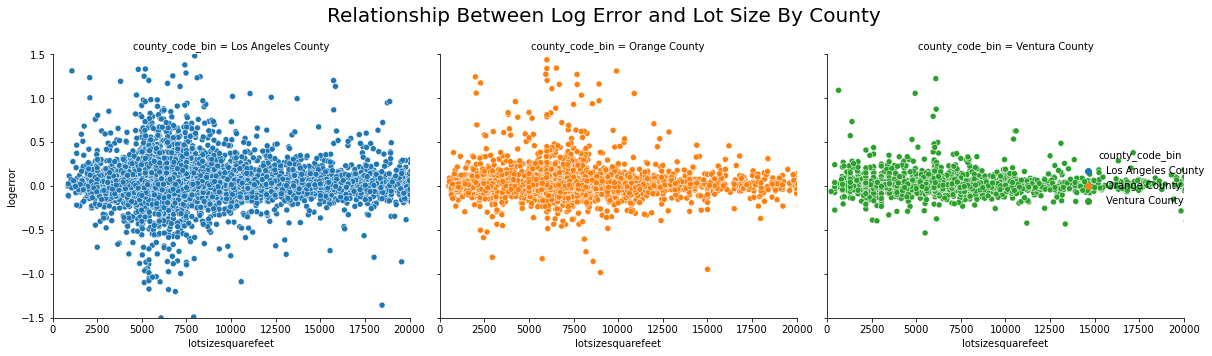

In [19]:
x = train.lotsizesquarefeet
y = train.logerror
# Set size of figure
plt.figure(figsize = (13,7))
# Create scatterplot
ax = sns.relplot(data=train, x= x, y= y, hue="county_code_bin", col="county_code_bin")
# set x and y limits to 'zoom in'
ax.set(xlim = (0, 20000), ylim= (-1.5,1.5)) # set the limits to the desired ones
# fit labels and legend
plt.suptitle('Relationship Between Log Error and Lot Size By County', fontsize = 20)
plt.yticks(fontsize = 14)
plt.ylabel('Log Error', fontsize = 16)


plt.tight_layout() 
plt.show()

#### Observations
- LA County and Orange County have more log error in homes with a lot size between 3000 - 8000 sqft. 
- Is logerror significntly different for homes with lot sizes between 3000-8000 sqft?

#### Hypothesis Testing - Pearson's R
Pearson's R was used because both lotsize and logerror are continuous variables. 

- H$_{0}$: There is no linear relationship between lot size and logerror.
- H$_{a}$: There is a linear realtionship between lot size and log error.

In [23]:
α = 0.05
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)
if p < α:
    print("We reject the H0.")
else:
    print("We fail to reject the H0.")

r = 0.01885414449791934
p = 0.00043284973126076913
We reject the H0.


Statistical testing with Pearson's R shows the data IS statistically relevant and we reject the null hypothesis that there is no linear relationship between lot size and logerror. 

---

### ANSWER 1: Yes, lot size correlates with logerror (r = 0.018).

======================================================================================================================================

### Question 2:

#### Is there a relationship between logerror and finished square footage of the property in each county?

#### Visualization 

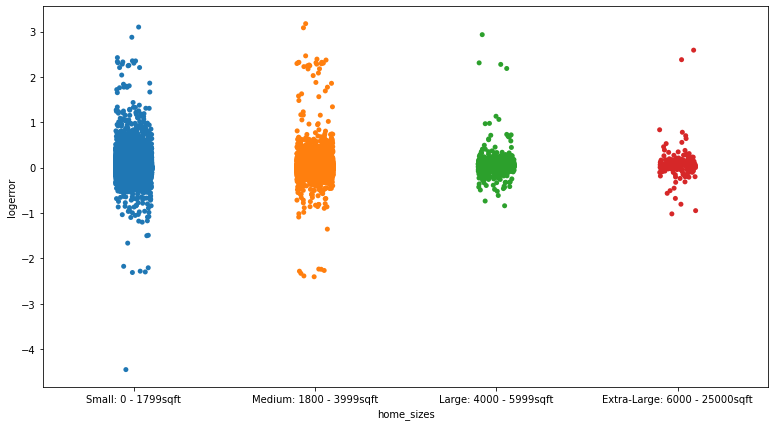

In [25]:
x = train.home_sizes
y = train.logerror
plt.figure(figsize = (13,7))
ax = sns.stripplot(x=x, y=y, data= train.sample(1000))

[(-1.0, 1.0)]

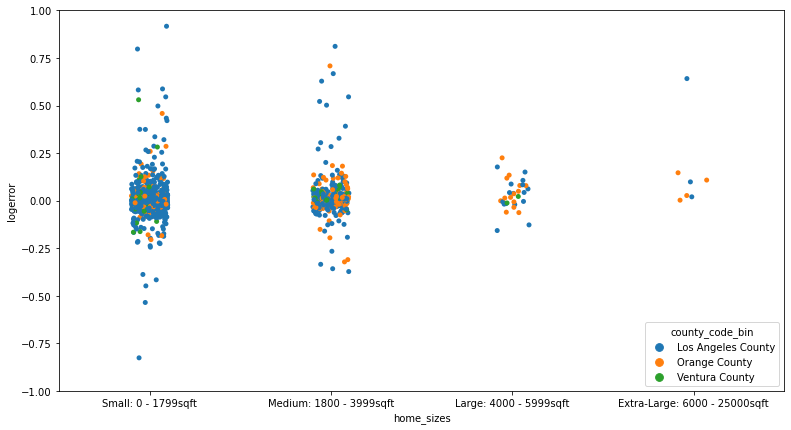

In [28]:
x = 'home_sizes'
y = 'logerror'
plt.figure(figsize = (13,7))
ax = sns.stripplot(x=x, y=y, hue='county_code_bin', data= train.sample(1000))
ax.set(ylim= (-1,1))

#### Hypothesis Testing - 1-Tailed, 1-Sample T-Test - Mean of Subgroup vs. Mean of Overall
T-Test was used to compare the mean of logerror of a sample against the mean logerror overall

- H$_{0}$: Mean of logerror in houses of less than 4000 square feet <= Mean logerror of all home sizes
- H$_{a}$:Mean of logerror in houses of less than 4000 square feet > Mean logerror of all home sizes

In [31]:
alpha = 0.05
logerror_small_med= train[(train.home_sizes.str.startswith('Small'))| (train.home_sizes.str.startswith('Medium'))].logerror
overall_mean = train.logerror.mean()
t, p = stats.ttest_1samp(logerror_small_med, overall_mean)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject the null hypothesis.")
else:
    print("We reject the null hypothesis.")

-1.283039461460382 0.0997435235734488 0.05
We fail to reject the null hypothesis.


Statistical testing with a T-Test shows the data IS NOT statistically relevant and we fail to reject the null hypothesis that mean of logerror in houses of less than 4000 square feet <= mean logerror of all home sizes.

---

### ANSWER 2: 
- No, houses with less than 4000 square feet does  .  No significant difference between the mean of ______ and the mean of ______.

======================================================================================================================================

### Question 3: 

#### Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

#### Visualization 

In [ ]:
sns.boxplot(train.logerror, train.county_code_bin)
plt.title("Is there a difference in logerror for each county?")
plt.show()

#### Visualization Takeaways

#### Hypothesis Testing 

---

### ANSWER 3: 

======================================================================================================================================

### Question 4:  

#### Is there a relationship between logerror and zipcode?

#### Visualization 

#### Visualization Takeaways

#### Hypothesis Testing 

### Question 4: 

#### Visualization 

---

======================================================================================================================================

### Question 5: 

#### Controlling for property square footage, what is the relationship between logerror and age of the home?

#### Visualization 

#### Visualization Takeaways

#### Hypothesis Testing 

======================================================================================================================================

### Question 6: 

#### Is there a realtionship between logerror and acres?

#### Visualization 

#### Visualization Takeaways

#### Hypothesis Testing 

---

======================================================================================================================================

## Exploration Summary:

======================================================================================================================================

#### Set X and y

In [34]:
target = "logerror"
columns = ['age', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'total_rooms', 'bathroomcnt', 'bedroomcnt', 'latitude', 'longitude']
# split train into X (dataframe, drop target) & y (series, keep target only)
X_train = train[columns]
y_train = train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
X_validate = validate[columns]
y_validate = validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
X_test = test[columns]
y_test = test[target]

In [33]:
# Observe size of train, validate, teest splits
X_train.shape, X_validate.shape, X_test.shape

---

## Clustering

After exploring through visualizations and statistical testing, a few features stood out as possiblities for clustering.  



- A. AGE & SQFT (age_size_cluster)
- B. AGE & LOT SIZE (age_lot_cluster)
- C. SQFT & LOT SIZE (size_cluster)
- 

### A. AGE & SQFT (age_size_cluster)

### Scale the Data

In [ ]:
#Exploring one version of clustering - scaling only applied to train for now until we determine it is useful
cluster_vars = ['age', 'calculatedfinishedsquarefeet']
cluster_name = 'age_size_cluster'

scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train[cluster_vars])

X_train_scaled = scaler.transform(X_train[cluster_vars])

In [ ]:
# Like our other scikit-learn models, we'll create the instance of the k-means class, then fit it to our data. Once we've done that, we can use the object to make predictions.
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_scaled)

kmeans.predict(X_train_scaled)

In [ ]:
#The numbers output here are the groups that our K-means algorithm predicted each row to be in. Let's go ahead and store the predicted cluster back into our original dataframe.
train['age_size_cluster'] = kmeans.predict(X_train_scaled)

In [ ]:
sns.scatterplot(x='age', y='calculatedfinishedsquarefeet', hue='age_size_cluster', data=train)
plt.title('Original Data with Cluster Labels')

In [ ]:
x = train.age_size_cluster
y = train.logerror
plt.figure(figsize = (13,7))
ax = sns.stripplot(x=x, y=y, data= train.sample(1000))

In [ ]:
train.groupby('age_size_cluster')['age', 'calculatedfinishedsquarefeet', 'logerror'].mean()

In [ ]:
### A. Observation:
- There is no significant difference, which tells us these clusters are not helpful in predicting logerror.
- The clusters appear to be older homes with smaller square footage. 
    - Age 89, 1500 sqft
    - Age 28, 2100 sqft
    - Age 58, 1600 sqft

---

### B. AGE & LOT SIZE (age_lot_cluster)

### Scale the Data

In [ ]:
#Exploring one version of clustering - scaling only applied to train for now until we determine it is useful
cluster_vars = ['age', 'lotsizesquarefeet']
cluster_name = 'age_lot_cluster'

scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train[cluster_vars])

X_train_scaled = scaler.transform(X_train[cluster_vars])

In [ ]:
# Like our other scikit-learn models, we'll create the instance of the k-means class, then fit it to our data. Once we've done that, we can use the object to make predictions.
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_scaled)

kmeans.predict(X_train_scaled)

In [ ]:
#The numbers output here are the groups that our K-means algorithm predicted each row to be in. Let's go ahead and store the predicted cluster back into our original dataframe.
train['age_lot_cluster'] = kmeans.predict(X_train_scaled)

In [ ]:
x = train.age_lot_cluster
y = train.logerror
plt.figure(figsize = (13,7))
ax = sns.stripplot(x=x, y=y, data= train.sample(1000))

In [ ]:
sns.scatterplot(x='age', y='lotsizesquarefeet', hue='age_size_cluster', data=train)
plt.title('Original Data with Cluster Labels')

In [ ]:
train.groupby('age_lot_cluster')['age', 'lotsizesquarefeet', 'logerror'].mean()

### B. Observation:
- There is no significant difference, which tells us these clusters are not helpful in predicting logerror.
- The clusters appear to be older homes with large lot size. 
    - Age 29, 49K sqft lot
    - Age 58, 20K sqft lot
    - Age 88, 9k sqft lot

---

### C. SQFT & LOT SIZE (size_cluster)

### Scale the Data

In [ ]:
#Exploring one version of clustering - scaling only applied to train for now until we determine it is useful
cluster_vars = ['calculatedfinishedsquarefeet', 'lotsizesquarefeet']
cluster_name = 'size_cluster'

scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train[cluster_vars])

X_train_scaled = scaler.transform(X_train[cluster_vars])

In [ ]:
# Like our other scikit-learn models, we'll create the instance of the k-means class, then fit it to our data. Once we've done that, we can use the object to make predictions.
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_scaled)

kmeans.predict(X_train_scaled)

In [ ]:
#The numbers output here are the groups that our K-means algorithm predicted each row to be in. Let's go ahead and store the predicted cluster back into our original dataframe.
train['size_cluster'] = kmeans.predict(X_train_scaled)

In [ ]:
x = train.size_cluster
y = train.logerror
plt.figure(figsize = (13,7))
ax = sns.stripplot(x=x, y=y, data= train.sample(1000))

In [ ]:
sns.scatterplot(x='lotsizesquarefeet', y='calculatedfinishedsquarefeet', hue='size_cluster', data=train)
plt.title('Original Data with Cluster Labels')

In [ ]:
train.groupby('size_cluster')['lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'logerror'].mean()

In [ ]:
### C. Observation:
- There is no significant difference, which tells us these clusters are not helpful in predicting logerror.

- The clusters appear to be small to medium sized square feet and large lot size. 
    - Lot 35K, Home 1,300 sq ft. 
    - Lot 24K, Home 4,500 sq ft. 
    - Lot 18K, Home 2,400 sq ft. 

---

### D. Latititude & Longitude (location_cluster)

### Scale the Data

In [ ]:
#Exploring one version of clustering - scaling only applied to train for now until we determine it is useful
cluster_vars = ['latitude', 'longitude']
cluster_name = 'location_cluster'

scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train[cluster_vars])

X_train_scaled = scaler.transform(X_train[cluster_vars])

In [ ]:
# Like our other scikit-learn models, we'll create the instance of the k-means class, then fit it to our data. Once we've done that, we can use the object to make predictions.
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_scaled)

kmeans.predict(X_train_scaled)

In [ ]:
#The numbers output here are the groups that our K-means algorithm predicted each row to be in. Let's go ahead and store the predicted cluster back into our original dataframe.
train['location_cluster'] = kmeans.predict(X_train_scaled)

In [ ]:
sns.scatterplot(x='latitude', y='longitude', hue='location_cluster', data=train)
plt.title('Original Data with Cluster Labels')

In [ ]:
x = train.location_cluster
y = train.logerror
plt.figure(figsize = (13,7))
ax = sns.stripplot(x=x, y=y, data= train.sample(1000))

In [ ]:
train.groupby('location_cluster')['latitude', 'longitude', 'logerror'].mean()

### D. Observation:
- There is no significant difference, which tells us these clusters are not helpful in predicting logerror.

- The clusters appear to be small to medium sized square feet and large lot size. 
    - Lot 35K, Home 1,300 sq ft. 
    - Lot 24K, Home 4,500 sq ft. 
    - Lot 18K, Home 2,400 sq ft. 

======================================================================================================================================

## DATA MODELING

Process of modeling involved:
- Set X and y with target as assessed_value
- Feature Engineering with RFE
- Set Baseline
- Create 4 models:
    - LinearRegression (OLS)
    - LASSO + LARS
    - Polynomial Regression
    -
- Evaluate the models

### Modeling

After setting the X and y, and conducting feature selection/engineering, the baseline was set and 4 models were produced:

- LinearRegression (OLS)
- LASSO + LARS
- Polynomial Regression

### Baseline

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# compute logerror_pred_median, setting the baseline on the median logerror.
y_train['baseline'] = y_train['logerror'].median()
y_validate['baseline'] = y_train.logerror.median()

### LASSO + LARS

In [ ]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series
lars.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lasso_lars'] = lars.predict(X_train)
y_validate['logerror_pred_lasso_lars']= lars.predict(X_validate)

In [ ]:
#'lotsizesquarefeet', 'total_rooms', 'bathroomcnt', 'bedroomcnt', 'latitude', 'longitude']

# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series
lars.fit(X_train[['age', 'calculatedfinishedsquarefeet']], y_train.logerror)

# predict train
y_train['logerror_pred_lasso_lars_age_sqft'] = lars.predict(X_train[['age', 'calculatedfinishedsquarefeet']])
y_validate['logerror_pred_lasso_lars_age_sqft']= lars.predict(X_validate[['age', 'calculatedfinishedsquarefeet']])

### Polynomial Regression

In [ ]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [ ]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)
#y_test = pd.DataFrame(y_test)

### Outcome of Modeling

In [ ]:
pd.options.display.float_format = '{:.6f}'.format
# Create a dataframe with model results for train and validate.
model_results = pd.concat([
    y_train.apply(lambda col: mean_squared_error(y_train.logerror, col)**(1/2)).rename('train'),
    y_validate.apply(lambda col: mean_squared_error(y_validate.logerror, col)**(1/2)).rename('validate')
], axis=1)
model_results.sort_values('validate')

---

### Best Performing Model Applied to Test Data (Unseen Data)

The model that performed best was the Polynomial Regression Model with a degree of 2. It has an RMSE of 543_097 on train, performing 32% better than the baseline of 803_309. It produced an RMSE of 516_091 on validate, performing 35% better than baseline. Due to it's perferred performance, it was applied to the test set. 

In [ ]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our test data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_test_degree2, y_test.assessed_value)

# predict train
y_test['assessed_value_pred_lm2'] = lm2.predict(X_test_degree2)


---

### Results of Model on Test Data

In [ ]:
# Create a dataframe with model results for train, validate, and test.
model_results = pd.concat([
    y_train.apply(lambda col: mean_squared_error(y_train.assessed_value, col)**(1/2)).rename('train'),
    y_validate.apply(lambda col: mean_squared_error(y_validate.assessed_value, col)**(1/2)).rename('validate'),
    y_test.apply(lambda col: mean_squared_error(y_test.assessed_value, col)**(1/2)).rename('test')
], axis=1)
model_results

The Polynomial Regression Model with a degree of 2, produced an RMSE of 535_871 on the unseen test data, 267_438, or 33%, better than baseline, which is how it would be expected to perform on future unseen data.

---

## CONCLUSION

### Summary
The goal of this report was to identify drivers of property tax assessed value for Single Family Residences and to use the drivers identified to construct an improved Machine Learning Regression Model which would predict property tax assessed values. 

Through the process of data acquisition, preparation, exploration, and statistical testing, it was determined drivers of property tax assessed value for Single Family Residences were (in order of significance):

- 1. total rooms (bedrooms and bathrooms combined)
- 1. location -> Orange County
- 1. location -> Ventura County
- 1. location -> Los Angeles County
- 2. year built
- 3. square feet

By using these more prominent features in multiple Machine Learning Regression models, predictions of property values were made with the best performing model, a Polynomial Regression Model with a degree of 2, producing an RMSE of 535_871 on the unseen test data, 267_438, or 33%, better than baseline, which is how it would be expected to perform on future unseen data.

### Recommendations for the Data Science Team

- USE THE IDENTIFIED DRIVERS of HOME VALUES: The data shows total rooms and location have the largest impact on property values. These features should be used going forward to predict home values, as well as a starting point for conducting further analysis.  

- BUILD UPON MODEL PERFORMANCE: Although the Polynomial Regression Model does predict home values with an RMSE of 535_871 on unseen data, the model could continue to be improved upon through deeper analysis of home features and their impact on property values. See next steps. 

- CONTINUE to PINPOINT HOME FEATURES DRIVING PROPERTY VALUES: This report focused on the number of rooms, square footage, and location as initial contributors to home value. It is recommended further analysis and modeling be done with additional features in order to create models with improved performance. 

### Next Steps

If given more time, further exploration would be beneficial in the following areas, in order to produce a more beneficial prediction model:
- Eliminating outliers and scaling data to produce more accurate modeling/predictions.

- Identifying more features of properties that may be drivers of property values, such as the size of lot, pools, or outbuildings, to obtain a more precise view of factors impacting property value. 

- Compare specific features to see which have more impact on property value, such as adding another room versus adding overall square footage to identify the dollar-for-dollar weight of specific features. 

- Analyzing feature impact within each county and comparing the impact across counties to determine which features have greater impact by location.